# Contrastive learning을 활용한 SSL(Self-Supervised Learning)

아래 세 그룹을 비교하여 SSL의 성능을 확인합니다.

1. Full data를 활용한 지도학습
2. 데이터를 일부만 활용한 지도학습
3. Contrastive learning으로 Pre-training + 데이터의 일부만 추출한 뒤 Fine-tuning 

## Prep

In [1]:
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"{device} ready!")

mps ready!


### 네트워크 설계

In [2]:
class SimCLRNet(nn.Module):
    def __init__(self, projection_dim=128, cls=False):
        super(SimCLRNet, self).__init__()
        self.cls = cls
        # 인코더 정의
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU()
        )
        # 프로젝션 헤드
        if self.cls == False:
            self.projection_head = nn.Sequential(
                nn.Linear(256, 64),
                nn.ReLU(),
                nn.Linear(64, projection_dim)
            )
        else:    
            self.classifier = nn.Sequential(
                nn.Linear(256, 10)
            )

    def forward(self, x):
        features = self.encoder(x)
        if self.cls == False:
            projections = self.projection_head(features)
            return projections
        else:
            logits = self.classifier(features)
            return logits

In [3]:
simclrnet = SimCLRNet(cls=False)
simclrnet

SimCLRNet(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1

In [4]:
cnn_1 = SimCLRNet(cls=True) # Full data Supervised learning
cnn_2 = SimCLRNet(cls=True) # Partial data Supervised learning

In [5]:
dummy_input = torch.randn(1, 3, 32, 32)
dummy_output_simclr = simclrnet(dummy_input)
dummy_output_cnn = cnn_1(dummy_input)

print(dummy_output_simclr.shape, dummy_output_cnn.shape)

torch.Size([1, 128]) torch.Size([1, 10])


In [6]:
# 기본 변환
transform_cnn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-10 데이터셋 로드
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cnn)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cnn)

total_length = len(train_dataset)
train_length = int(len(train_dataset) * 0.8)

train_subset, val_subset = random_split(train_dataset, [train_length, total_length - train_length])

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)

val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# CIFAR-10 클래스 (라벨)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170498071/170498071 [00:14<00:00, 12024292.39it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
print(f"Train size: {len(train_subset)}\nVal size: {len(val_subset)}\nTest size: {len(test_dataset)}")

Train size: 40000
Val size: 10000
Test size: 10000


# 비교 실험

## Vanilla CNN - Full data supervised learning

In [8]:
CE_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_1.parameters(), lr=3e-4, weight_decay=0.001)
cnn_1.to(device)

SimCLRNet(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1

In [9]:
def supervised_train_validate(model, train_loader, val_loader, optimizer, criterion, epochs, device):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    model.to(device)
    
    for epoch in range(epochs):
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        model.train()
        
        for x, y in tqdm(train_loader):
            x = x.to(device)
            y = y.to(device)
            
            optimizer.zero_grad()
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * x.size(0)
            train_total += y.size(0)
            train_correct += (pred.argmax(1) == y).sum().item()

        train_loss /= train_total
        train_acc = train_correct / train_total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        print(f"Epoch {epoch+1}\nTrain Loss: {train_loss:.4f}\tTrain Accuracy: {train_acc:.4f}")


        val_loss = 0.0
        val_correct = 0
        val_total = 0
        model.eval()
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.to(device)
                
                pred = model(x)
                loss = criterion(pred, y)
            
                val_loss += loss.item() * x.size(0)
                val_total += y.size(0)
                val_correct += (pred.argmax(1) == y).sum().item()
                
        val_loss /= val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Val Loss: {val_loss:.4f}\tVal Accuracy: {val_acc:.4f}")
        
    return train_losses, train_accs, val_losses, val_accs

In [10]:
train_losses, train_accs, val_losses, val_accs = supervised_train_validate(cnn_1, train_loader, test_loader, optimizer, CE_loss, 10, device)

100%|██████████| 313/313 [00:59<00:00,  5.23it/s]


Epoch 1
Train Loss: 1.8820	Train Accuracy: 0.2933
Val Loss: 1.6163	Val Accuracy: 0.3895


100%|██████████| 313/313 [00:54<00:00,  5.70it/s]


Epoch 2
Train Loss: 1.4971	Train Accuracy: 0.4425
Val Loss: 1.4387	Val Accuracy: 0.4733


100%|██████████| 313/313 [00:40<00:00,  7.75it/s]


Epoch 3
Train Loss: 1.2856	Train Accuracy: 0.5295
Val Loss: 1.2990	Val Accuracy: 0.5298


100%|██████████| 313/313 [00:40<00:00,  7.70it/s]


Epoch 4
Train Loss: 1.1288	Train Accuracy: 0.5924
Val Loss: 1.0927	Val Accuracy: 0.6065


100%|██████████| 313/313 [00:39<00:00,  7.86it/s]


Epoch 5
Train Loss: 0.9991	Train Accuracy: 0.6438
Val Loss: 1.0017	Val Accuracy: 0.6399


100%|██████████| 313/313 [00:40<00:00,  7.72it/s]


Epoch 6
Train Loss: 0.8905	Train Accuracy: 0.6813
Val Loss: 0.9268	Val Accuracy: 0.6712


100%|██████████| 313/313 [00:40<00:00,  7.82it/s]


Epoch 7
Train Loss: 0.8065	Train Accuracy: 0.7120
Val Loss: 0.8651	Val Accuracy: 0.6920


100%|██████████| 313/313 [00:40<00:00,  7.81it/s]


Epoch 8
Train Loss: 0.7288	Train Accuracy: 0.7429
Val Loss: 0.8407	Val Accuracy: 0.7063


100%|██████████| 313/313 [00:40<00:00,  7.82it/s]


Epoch 9
Train Loss: 0.6546	Train Accuracy: 0.7698
Val Loss: 0.8100	Val Accuracy: 0.7140


100%|██████████| 313/313 [00:48<00:00,  6.50it/s]


Epoch 10
Train Loss: 0.5850	Train Accuracy: 0.7921
Val Loss: 0.7986	Val Accuracy: 0.7262


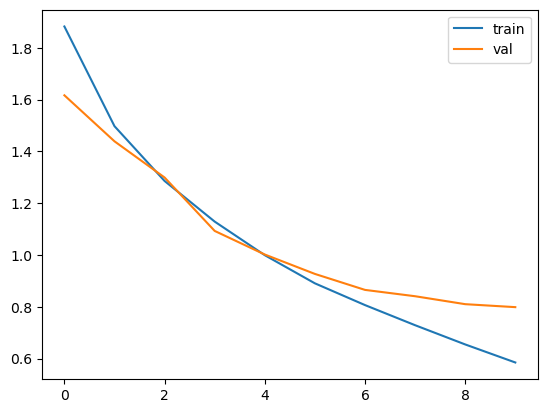

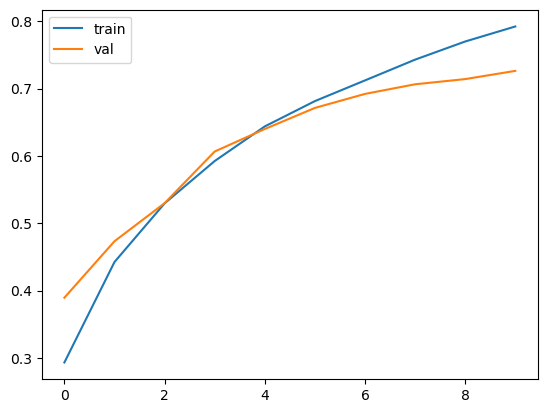

In [11]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()
plt.plot(train_accs, label='train')
plt.plot(val_accs, label='val')
plt.legend()
plt.show()

## Supervised learning with partial data only

In [12]:
CE_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_2.parameters(), lr=3e-4, weight_decay=0.001)
cnn_2.to(device)

SimCLRNet(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1

In [13]:
part_train_losses, part_train_accs, part_val_losses, part_val_accs = supervised_train_validate(cnn_2, val_loader, test_loader, optimizer, CE_loss, 10, device)

100%|██████████| 79/79 [00:11<00:00,  6.92it/s]


Epoch 1
Train Loss: 2.1635	Train Accuracy: 0.1863
Val Loss: 2.0245	Val Accuracy: 0.2493


100%|██████████| 79/79 [00:10<00:00,  7.54it/s]


Epoch 2
Train Loss: 1.9700	Train Accuracy: 0.2608
Val Loss: 1.8607	Val Accuracy: 0.3069


100%|██████████| 79/79 [00:10<00:00,  7.64it/s]


Epoch 3
Train Loss: 1.8096	Train Accuracy: 0.3126
Val Loss: 1.8094	Val Accuracy: 0.3148


100%|██████████| 79/79 [00:10<00:00,  7.75it/s]


Epoch 4
Train Loss: 1.6891	Train Accuracy: 0.3573
Val Loss: 1.6778	Val Accuracy: 0.3569


100%|██████████| 79/79 [00:10<00:00,  7.68it/s]


Epoch 5
Train Loss: 1.6021	Train Accuracy: 0.3932
Val Loss: 1.6047	Val Accuracy: 0.3947


100%|██████████| 79/79 [00:10<00:00,  7.79it/s]


Epoch 6
Train Loss: 1.5091	Train Accuracy: 0.4339
Val Loss: 1.5195	Val Accuracy: 0.4291


100%|██████████| 79/79 [00:10<00:00,  7.75it/s]


Epoch 7
Train Loss: 1.4377	Train Accuracy: 0.4631
Val Loss: 1.4533	Val Accuracy: 0.4556


100%|██████████| 79/79 [00:10<00:00,  7.72it/s]


Epoch 8
Train Loss: 1.3672	Train Accuracy: 0.4930
Val Loss: 1.3895	Val Accuracy: 0.4849


100%|██████████| 79/79 [00:10<00:00,  7.71it/s]


Epoch 9
Train Loss: 1.2924	Train Accuracy: 0.5230
Val Loss: 1.3436	Val Accuracy: 0.5128


100%|██████████| 79/79 [00:10<00:00,  7.51it/s]


Epoch 10
Train Loss: 1.2163	Train Accuracy: 0.5517
Val Loss: 1.3260	Val Accuracy: 0.5217


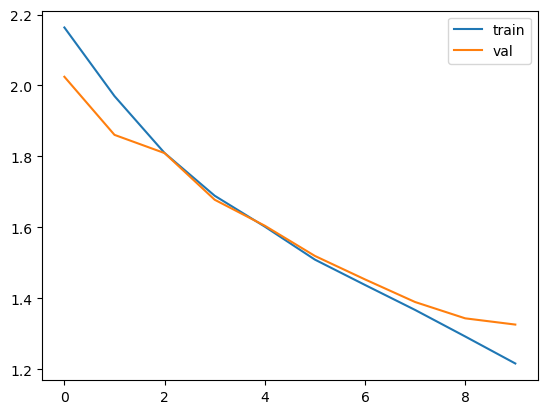

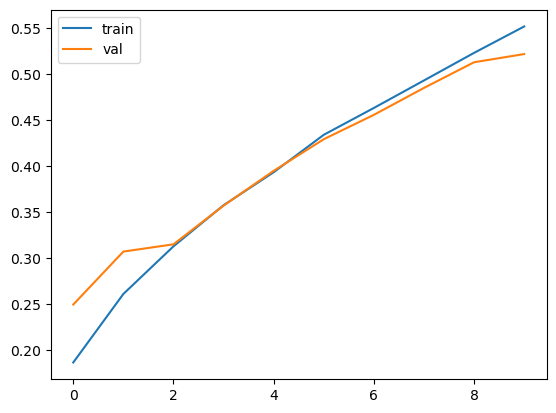

In [14]:
plt.plot(part_train_losses, label='train')
plt.plot(part_val_losses, label='val')
plt.legend()
plt.show()
plt.plot(part_train_accs, label='train')
plt.plot(part_val_accs, label='val')
plt.legend()
plt.show()

## Pre-training & Finetuning

### Pre-training with Contrastive learning

In [15]:
transform_simclr = transforms.Compose([
    transforms.RandomResizedCrop(size=32, scale=(0.2, 1.)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class CIFAR10SimCLR(torchvision.datasets.CIFAR10):
    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        
        x_1 = self.transform(img)
        x_2 = self.transform(img)

        return x_1, x_2, target

In [16]:
simclr_dataset = CIFAR10SimCLR(root='./data', train=True, download=True, transform=transform_simclr)

simclr_loader = DataLoader(simclr_dataset, batch_size=128, shuffle=True)

Files already downloaded and verified


torch.Size([3, 32, 32]) torch.Size([3, 32, 32]) 6


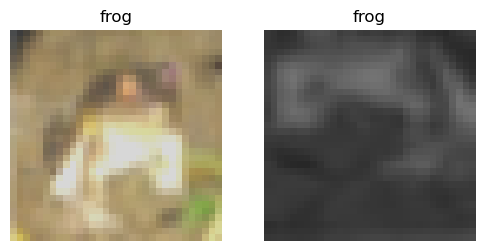

torch.Size([3, 32, 32]) torch.Size([3, 32, 32]) 9


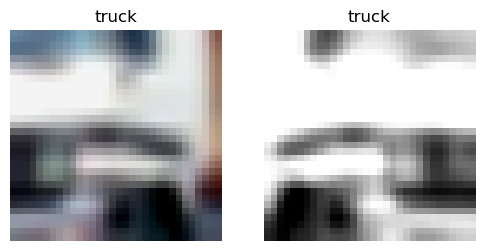

torch.Size([3, 32, 32]) torch.Size([3, 32, 32]) 9


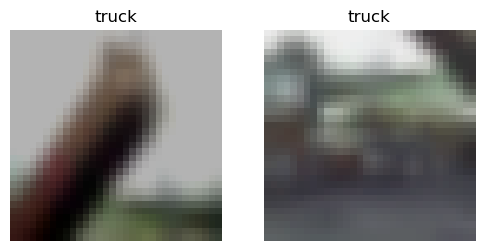

torch.Size([3, 32, 32]) torch.Size([3, 32, 32]) 4


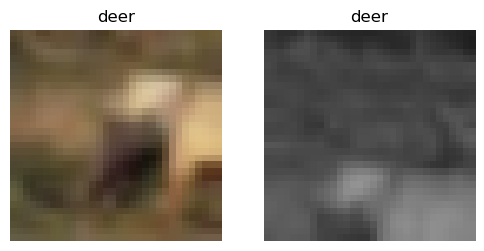

torch.Size([3, 32, 32]) torch.Size([3, 32, 32]) 1


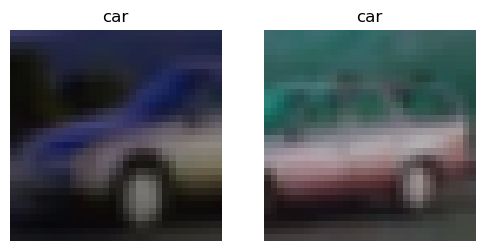

torch.Size([3, 32, 32]) torch.Size([3, 32, 32]) 1


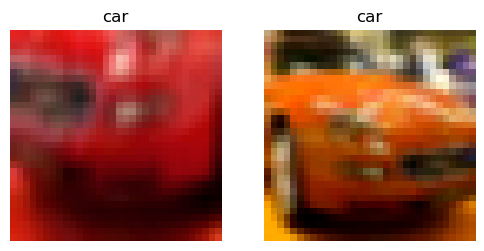

torch.Size([3, 32, 32]) torch.Size([3, 32, 32]) 2


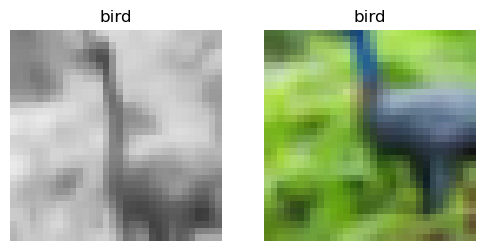

torch.Size([3, 32, 32]) torch.Size([3, 32, 32]) 7


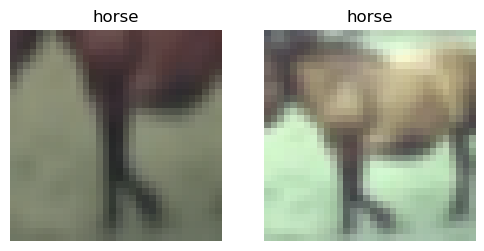

torch.Size([3, 32, 32]) torch.Size([3, 32, 32]) 8


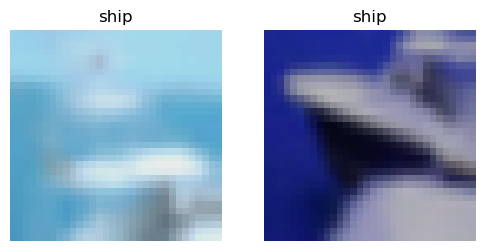

torch.Size([3, 32, 32]) torch.Size([3, 32, 32]) 3


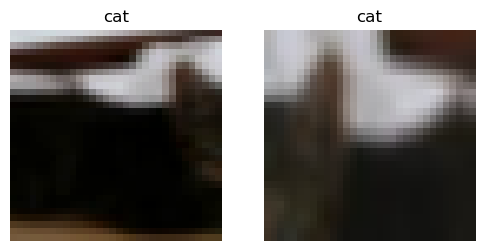

In [17]:
for i in range(10):
    x1, x2, y = simclr_dataset[i]
    print(x1.shape, x2.shape, y)

    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    x1 = (x1.permute(1, 2, 0) * 0.5 + 0.5).numpy()
    x2 = (x2.permute(1, 2, 0) * 0.5 + 0.5).numpy()
    
    axes[0].imshow(x1)
    axes[0].axis('off')
    axes[0].set_title(classes[y])
    axes[1].imshow(x2)
    axes[1].axis('off')
    axes[1].set_title(classes[y])

    plt.show()  # 그래프 표시

In [18]:
# NT-Xent Loss 정의
def nt_xent_loss(z_i, z_j, temperature=0.5):
    batch_size = z_i.shape[0]
    z = torch.cat([z_i, z_j], dim=0)
    
    # 벡터 정규화 (각 벡터의 길이를 1로 맞춤)
    sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)
    sim_exp = torch.exp(sim / temperature)
    
    mask = torch.eye(2 * batch_size, dtype=torch.bool).to(z.device)
    sim_exp = sim_exp.masked_fill(mask, 0)
    
    pos_sim = torch.exp(F.cosine_similarity(z_i, z_j) / temperature)
    loss = -torch.log(pos_sim / (sim_exp.sum(dim=1)[:batch_size] + sim_exp.sum(dim=1)[batch_size:]))
    return loss.mean()

In [19]:
def pretrain_simclr(model, dataloader, optimizer, epochs=10, temperature=0.5):
    model.to(device)
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for x_1, x_2, _ in tqdm(dataloader):
            x_1 = x_1.to(device)
            x_2 = x_2.to(device)
            
            # 두 이미지의 특징 벡터 추출
            z_i = model(x_1)
            z_j = model(x_2)

            # NT-Xent 손실 계산
            loss = nt_xent_loss(z_i, z_j, temperature)

            # 옵티마이저 업데이트
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss/len(dataloader):.4f}")
    
    return model

In [20]:
simclr_optim = optim.Adam(simclrnet.parameters(), lr=0.001)

In [21]:
pretrain_simclr(simclrnet, simclr_loader, simclr_optim, epochs=10, temperature=0.5)

100%|██████████| 391/391 [03:02<00:00,  2.14it/s]


Epoch [1/10] Loss: 5.9236


100%|██████████| 391/391 [02:55<00:00,  2.23it/s]


Epoch [2/10] Loss: 5.5951


100%|██████████| 391/391 [02:55<00:00,  2.23it/s]


Epoch [3/10] Loss: 5.4089


100%|██████████| 391/391 [03:01<00:00,  2.16it/s]


Epoch [4/10] Loss: 5.2847


100%|██████████| 391/391 [02:56<00:00,  2.21it/s]


Epoch [5/10] Loss: 5.1966


100%|██████████| 391/391 [03:00<00:00,  2.17it/s]


Epoch [6/10] Loss: 5.1319


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


Epoch [7/10] Loss: 5.0865


100%|██████████| 391/391 [02:51<00:00,  2.27it/s]


Epoch [8/10] Loss: 5.0475


100%|██████████| 391/391 [02:53<00:00,  2.26it/s]


Epoch [9/10] Loss: 5.0067


100%|██████████| 391/391 [02:52<00:00,  2.27it/s]

Epoch [10/10] Loss: 4.9778


SimCLRNet(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1

### Fine-tuning

In [22]:
# Fine-tuning을 위한 분류기로 전환
finetune_model = SimCLRNet(cls=True).to(device)

# 인코더 가중치 복사 (사전 학습된 인코더 사용)
finetune_model.encoder.load_state_dict(simclrnet.encoder.state_dict())

# 옵티마이저와 손실 함수 설정
finetune_optim = optim.Adam(finetune_model.parameters(), lr=3e-4, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()

In [23]:
simclr_train_losses, simclr_train_accs, simclr_val_losses, simclr_val_accs = supervised_train_validate(finetune_model, val_loader, test_loader, finetune_optim, criterion, epochs=10, device=device)

100%|██████████| 79/79 [00:09<00:00,  8.30it/s]


Epoch 1
Train Loss: 43.8277	Train Accuracy: 0.1696
Val Loss: 2.6386	Val Accuracy: 0.2099


100%|██████████| 79/79 [00:09<00:00,  8.34it/s]


Epoch 2
Train Loss: 2.1038	Train Accuracy: 0.2660
Val Loss: 1.8578	Val Accuracy: 0.3283


100%|██████████| 79/79 [00:09<00:00,  8.33it/s]


Epoch 3
Train Loss: 1.7228	Train Accuracy: 0.3783
Val Loss: 1.6433	Val Accuracy: 0.3928


100%|██████████| 79/79 [00:10<00:00,  7.88it/s]


Epoch 4
Train Loss: 1.5606	Train Accuracy: 0.4343
Val Loss: 1.5273	Val Accuracy: 0.4448


100%|██████████| 79/79 [00:10<00:00,  7.85it/s]


Epoch 5
Train Loss: 1.4534	Train Accuracy: 0.4747
Val Loss: 1.4555	Val Accuracy: 0.4718


100%|██████████| 79/79 [00:09<00:00,  8.43it/s]


Epoch 6
Train Loss: 1.3737	Train Accuracy: 0.5067
Val Loss: 1.4004	Val Accuracy: 0.4950


100%|██████████| 79/79 [00:09<00:00,  8.16it/s]


Epoch 7
Train Loss: 1.3080	Train Accuracy: 0.5293
Val Loss: 1.3610	Val Accuracy: 0.5081


100%|██████████| 79/79 [00:09<00:00,  8.34it/s]


Epoch 8
Train Loss: 1.2570	Train Accuracy: 0.5526
Val Loss: 1.3256	Val Accuracy: 0.5210


100%|██████████| 79/79 [00:09<00:00,  8.33it/s]


Epoch 9
Train Loss: 1.2109	Train Accuracy: 0.5691
Val Loss: 1.2944	Val Accuracy: 0.5344


100%|██████████| 79/79 [00:09<00:00,  8.33it/s]


Epoch 10
Train Loss: 1.1704	Train Accuracy: 0.5828
Val Loss: 1.2712	Val Accuracy: 0.5426


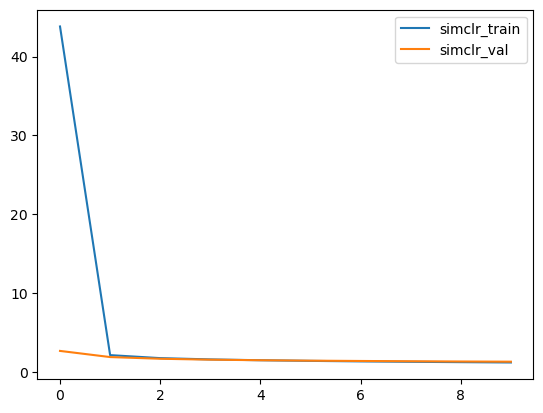

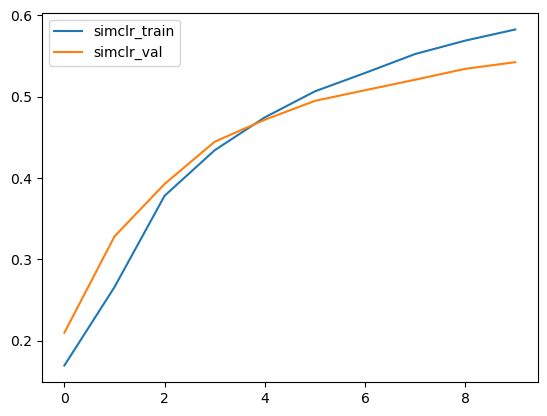

In [24]:
plt.plot(simclr_train_losses, label='simclr_train')
plt.plot(simclr_val_losses, label='simclr_val')
plt.legend()
plt.show()

plt.plot(simclr_train_accs, label='simclr_train')
plt.plot(simclr_val_accs, label='simclr_val')
plt.legend()
plt.show()

## 결과 비교

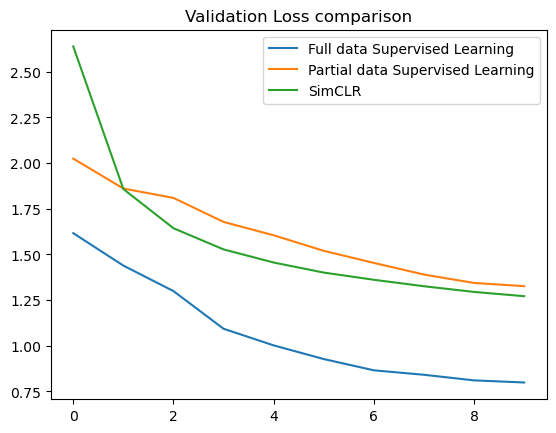

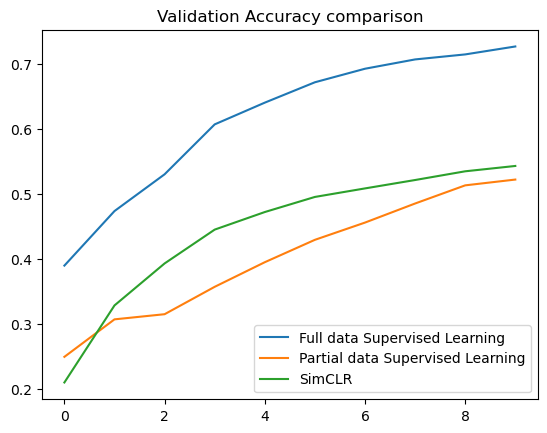

In [25]:
plt.title('Validation Loss comparison')
plt.plot(val_losses, label='Full data Supervised Learning')
plt.plot(part_val_losses, label='Partial data Supervised Learning')
plt.plot(simclr_val_losses, label='SimCLR')
plt.legend()
plt.show()

plt.title('Validation Accuracy comparison')
plt.plot(val_accs, label='Full data Supervised Learning')
plt.plot(part_val_accs, label='Partial data Supervised Learning')
plt.plot(simclr_val_accs, label='SimCLR')
plt.legend()
plt.show()